In [1]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
# Import all files that we will use
directory = r'C:/Users/moallemie/OneDrive - Deakin University/My Library/Deakin/Publications_Deakin/Local sustainability/meta-analysis/revision/'
files = ['scopus_2015.csv',
         'scopus_2016.csv',
         'scopus_2017.csv', 
         'scopus_2018.csv', 
         'scopus_2019.csv'
        ]

## Data preparation - Parsing the text file

In [3]:
# Clean documents

import pandas as pd

dfdoc2015 = pd.read_csv(directory+files[0])
dfdoc2016 = pd.read_csv(directory+files[1])
dfdoc2017 = pd.read_csv(directory+files[2])
dfdoc2018 = pd.read_csv(directory+files[3])
dfdoc2019 = pd.read_csv(directory+files[4])

dfdoc = pd.concat([dfdoc2015, dfdoc2016, dfdoc2017,dfdoc2018, dfdoc2019], axis=0, ignore_index=True)

#drop duplicates
dfdoc.drop_duplicates(subset='Title', inplace=True)

#drop those with no abstracts
dfdoc = dfdoc.dropna(axis=0, subset=['Abstract'])

In [4]:
## Call stopwords from the file

stopwords =[]
with open(directory+'stopwords.txt', 'r') as f:      
    for line in f:
        word=line.rstrip()
        stopwords.append(word)
f.close()


#print(stopwords)

In [5]:
# remove common words,stopwords,lemmatise, and tokenise - create a string corpus (a list of all words in a list of all abstracts)


import collections as c
import nltk 
from nltk.tokenize import sent_tokenize
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer

stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer() 

# create a dictionary to save your work
counter_dict = {}
all_words = c.Counter()
all_abstracts = []



# Get the article id
for index, row in dfdoc.iterrows():
    
    # Initialize your counts and lists
    # This is reset with every article
    content = c.Counter()
    stopwordcount = 0

    abstract = row['Abstract']
    

    # Remove most punctuation
    #depunct = re.sub('[;,\.]@','',abstract) 
    depunct = "".join(c for c in abstract if c not in [':', ',', ';', '.', '-', '@', '(', ')']) 
    # Remove upper case
    low = depunct.lower()
    # make a list of words
    words = low.split(" ")
    all_words_abstract = []
    for word in words:
        if word in stopwords:
            # if its a stopword count it 
            stopwordcount+=1
        else:
            # if its a content word, stem it and count it
            stem = stemmer.stem(word)
            content[stem]+=1
            all_words_abstract.append(stem)
    
    # add all words per abstract to a single list for topic modellign with gensim
    all_abstracts.append(all_words_abstract)

    # add all the stopwords under a single count
    content['allstopwords']=stopwordcount

    # keep track of the total list of words
    all_words+=content

    # make a dictionary of counters, one for each abstract

    counter_dict[index]=content

    # start again on the next article


In [30]:
len(counter_dict)

7961

In [6]:
#most common words in the collection of all these abstracts
print(all_words.most_common(50))

[('allstopwords', 795940), ('develop', 16695), ('sustain', 16325), ('urban', 12002), ('citi', 10633), ('area', 6179), ('system', 5486), ('environment', 5382), ('water', 5005), ('energi', 4857), ('result', 4607), ('rural', 4510), ('econom', 4376), ('local', 4242), ('social', 4237), ('manag', 4182), ('commun', 4163), ('plan', 3888), ('land', 3887), ('polici', 3817), ('region', 3630), ('resourc', 3295), ('increas', 3267), ('impact', 3235), ('data', 3195), ('base', 3083), ('improv', 2964), ('assess', 2948), ('import', 2940), ('level', 2896), ('process', 2849), ('environ', 2700), ('govern', 2699), ('chang', 2676), ('product', 2669), ('author', 2649), ('effect', 2560), ('method', 2559), ('provid', 2471), ('natur', 2365), ('evalu', 2355), ('build', 2322), ('indic', 2319), ('public', 2303), ('countri', 2298), ('strategi', 2280), ('project', 2263), ('implement', 2254), ('ecolog', 2251), ('includ', 2249)]


In [8]:
del_words = ['allstopwords', 'develop', 'system', 'area', 'social', 'implement', 'identifi', 'evalu', 'base',
             'sustain', 'manag', 'data', 'increas', '2018', '2017', '2019', '2030', 'author', 'method', 
             'publish', 'framework', 'project', 'assess', 'increas', 'process', 'result', 'support', 'indic', 'integr', 'factor',
              'local', 'level', 'practic', 'address', 'case', 'inform', 'goal', 'challeng', 'global', 
             'effect', 'countri', 'find', 'aim', 'potenti', 'perform', 'propos', 'propos', 'understand', 'includ', 
             'elsevi', 'contribut', 'relat', 'requir', 'qualiti', 'intern', 'role', 'issu', 'articl', 'discuss', 'chang', 
             'improv', 'provid', 'impact','signific', 'achiev', 'promot', 'build', 'univers', 'activ', 'reduc', 'group', 
             'analyz', 'show', 'futur', 'context', '2016', 'region', 'year', 'high', 'time', 'limit', 'problem', '2015', 'appli', 'key', 
             'china']
for key in del_words:
    if key in all_words:
        del all_words[key]
    if key in counter_dict:
        del counter_dict[key]

In [9]:
df_wordcount = pd.DataFrame(all_words.most_common(50))
#df_wordcount['words'] = df_wordcount.index.values
#df_wordcount['wordcount'] = df_wordcount[0]
df_wordcount.columns = ['words', 'wordcount']
df_wordcount

,words,wordcount
0,urban,12002
1,citi,10633
2,environment,5382
3,water,5005
4,energi,4857
5,rural,4510
6,econom,4376
7,commun,4163
8,plan,3888
9,land,3887


In [10]:
# prepare the data
import pandas as pd
#from memory_profiler import profile

df_counter = pd.DataFrame.from_dict(counter_dict, orient='index')
for word in del_words:
    if word in list(df_counter.columns):
        del df_counter[word]

In [11]:
# fill in the missing values with zeros
df_counter.fillna(0, inplace=True)
# convert the data to integers
df_counter = df_counter.astype(int)
# find and eliminate any records which have no data
doc_count=df_counter.sum(axis='columns')
print(len(df_counter[doc_count!=0]))
df_counter = df_counter[doc_count != 0]

7961


In [ ]:
df_counter.shape

In [12]:
import lda
import time 

a = time.time()

model7 = lda.LDA(n_topics=9, n_iter=3000, random_state=1)
model7 = model7.fit(df_counter.values) 
b = time.time()
c = b-a
print("time taken is", c)

2020-04-08 08:19:36,059 : INFO : n_documents: 7961
2020-04-08 08:19:36,060 : INFO : vocab_size: 41559
2020-04-08 08:19:36,061 : INFO : n_words: 784321
2020-04-08 08:19:36,062 : INFO : n_topics: 9
2020-04-08 08:19:36,062 : INFO : n_iter: 3000
2020-04-08 08:19:47,406 : INFO : <0> log likelihood: -8470917
2020-04-08 08:19:47,973 : INFO : <10> log likelihood: -7117812
2020-04-08 08:19:48,509 : INFO : <20> log likelihood: -6823786
2020-04-08 08:19:49,019 : INFO : <30> log likelihood: -6727192
2020-04-08 08:19:49,537 : INFO : <40> log likelihood: -6682023
2020-04-08 08:19:50,043 : INFO : <50> log likelihood: -6654645
2020-04-08 08:19:50,572 : INFO : <60> log likelihood: -6635350
2020-04-08 08:19:51,139 : INFO : <70> log likelihood: -6624196
2020-04-08 08:19:51,646 : INFO : <80> log likelihood: -6614811
2020-04-08 08:19:52,192 : INFO : <90> log likelihood: -6607434
2020-04-08 08:19:52,717 : INFO : <100> log likelihood: -6599587
2020-04-08 08:19:53,268 : INFO : <110> log likelihood: -6596247
2

2020-04-08 08:20:52,967 : INFO : <1250> log likelihood: -6538001
2020-04-08 08:20:53,510 : INFO : <1260> log likelihood: -6536332
2020-04-08 08:20:54,017 : INFO : <1270> log likelihood: -6535668
2020-04-08 08:20:54,580 : INFO : <1280> log likelihood: -6537614
2020-04-08 08:20:55,128 : INFO : <1290> log likelihood: -6538647
2020-04-08 08:20:55,626 : INFO : <1300> log likelihood: -6536823
2020-04-08 08:20:56,129 : INFO : <1310> log likelihood: -6536820
2020-04-08 08:20:56,627 : INFO : <1320> log likelihood: -6538000
2020-04-08 08:20:57,128 : INFO : <1330> log likelihood: -6536927
2020-04-08 08:20:57,656 : INFO : <1340> log likelihood: -6534310
2020-04-08 08:20:58,168 : INFO : <1350> log likelihood: -6537224
2020-04-08 08:20:58,679 : INFO : <1360> log likelihood: -6537726
2020-04-08 08:20:59,184 : INFO : <1370> log likelihood: -6537382
2020-04-08 08:20:59,688 : INFO : <1380> log likelihood: -6539526
2020-04-08 08:21:00,195 : INFO : <1390> log likelihood: -6537990
2020-04-08 08:21:00,723 :

2020-04-08 08:21:58,236 : INFO : <2520> log likelihood: -6537073
2020-04-08 08:21:58,784 : INFO : <2530> log likelihood: -6537033
2020-04-08 08:21:59,283 : INFO : <2540> log likelihood: -6535849
2020-04-08 08:21:59,802 : INFO : <2550> log likelihood: -6535154
2020-04-08 08:22:00,323 : INFO : <2560> log likelihood: -6536914
2020-04-08 08:22:00,835 : INFO : <2570> log likelihood: -6536760
2020-04-08 08:22:01,329 : INFO : <2580> log likelihood: -6534804
2020-04-08 08:22:01,838 : INFO : <2590> log likelihood: -6537949
2020-04-08 08:22:02,354 : INFO : <2600> log likelihood: -6534766
2020-04-08 08:22:02,902 : INFO : <2610> log likelihood: -6534201
2020-04-08 08:22:03,402 : INFO : <2620> log likelihood: -6536194
2020-04-08 08:22:03,910 : INFO : <2630> log likelihood: -6537590
2020-04-08 08:22:04,407 : INFO : <2640> log likelihood: -6535970
2020-04-08 08:22:04,926 : INFO : <2650> log likelihood: -6535714
2020-04-08 08:22:05,423 : INFO : <2660> log likelihood: -6535339
2020-04-08 08:22:05,923 :

time taken is 167.11924624443054


In [13]:
# Not important. Just because I forgot to change 7 to 9 in the name of variable in the cell above
model9 = model7

import numpy as np
#the number of documents in each group
column_sum = np.sum(model9.doc_topic_, axis=0)
column_sum

array([ 585.0284307 , 1191.02958582, 1103.50589086,  495.69394712,
       1561.66844034, 1022.46482268,  697.53050886,  719.65291132,
        584.4254623 ])

In [14]:
model9.doc_topic_

array([[8.55431993e-04, 8.55431993e-04, 1.37724551e-01, ...,
        8.55431993e-04, 9.40975192e-03, 1.79640719e-02],
       [6.94927033e-04, 6.94927033e-04, 1.45934677e-02, ...,
        6.94927033e-04, 7.37317582e-01, 1.25781793e-01],
       [9.26784059e-04, 6.58016682e-02, 9.26784059e-04, ...,
        9.26784059e-04, 9.26784059e-04, 9.26784059e-04],
       ...,
       [8.30324910e-02, 1.13976276e-01, 4.69314079e-02, ...,
        5.15729758e-04, 1.59876225e-02, 6.24033007e-02],
       [6.48492623e-01, 6.41436818e-04, 2.12315587e-01, ...,
        6.41436818e-04, 1.16100064e-01, 1.34701732e-02],
       [8.23101410e-02, 4.54752160e-04, 5.32514779e-01, ...,
        3.22874034e-02, 4.54752160e-04, 2.32378354e-01]])

In [15]:
topic_word = model9.topic_word_  
n_top_words = 20
word_array = np.array(df_counter.columns)

for i, topic in enumerate(topic_word):
    topic_words = word_array[np.argsort(topic)][:-n_top_words:-1]
    print('Topic {}: {}'.format(i+1, ' '.join(topic_words)))

Topic 1: water resourc flood suppli risk pollut surfac groundwat climat sourc temperatur river soil air treatment heat irrig concentr wastewat
Topic 2: citi urban transport plan smart design green space public network infrastructur environment environ hous tool decis strategi import mobil
Topic 3: rural econom environment polici product economi industri govern public commun sector market busi resourc territori import servic financi innov
Topic 4: agricultur land product food forest ecosystem rural conserv farm servic livelihood natur biodivers landscap speci crop farmer secur soil
Topic 5: urban polici citi commun govern plan climat environment nation initi polit action resili econom institut strategi adapt innov concept
Topic 6: urban citi land ecolog spatial econom growth industri resourc environment pattern index plan popul environ polici effici construct import
Topic 7: tourism educ cultur commun heritag environment student tourist natur rural import learn percept environ school be

In [31]:
topic_titles = ['SDGs 6', 
                'SDGs 9, 11, 16', 
                'SDGs 1, 8, 16', 
                'SDGs 2, 14, 15', 
                'SDGs 11, 13, 16, 17', 
                'SDGs 8, 9, 11, 15',
                'SDGs 1, 4', 
                'SDGs 7, 12, 13', 
                'SDGs 1, 3, 5, 10']

In [32]:
topic_dict = {}
for i, topic in enumerate(topic_word):
    top_words = word_array[np.argsort(topic)][:-51:-1]
    top_fracts = np.sort(topic)[:-51:-1]
    topic_dict[topic_titles[i]] = (top_words, top_fracts)
    

In [ ]:
topic_dict

In [33]:
#Write the topic contents into csv, make a df first
writer = pd.ExcelWriter(directory+'TopicWords_Dataset2.xlsx', engine='xlsxwriter')
workbook = writer.book
for key, data in topic_dict.items():
    df = pd.DataFrame(list(data))
    df = df.T
    df.to_excel(writer, sheet_name=key)


writer.save()

In [34]:
from wordcloud import (WordCloud, get_single_color_func)

class SimpleGroupedColorFunc(object):
    """Create a color function object which assigns EXACT colors
       to certain words based on the color to words mapping

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)


class GroupedColorFunc(object):
    """Create a color function object which assigns DIFFERENT SHADES of
       specified colors to certain words based on the color to words mapping.

       Uses wordcloud.get_single_color_func

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.color_func_to_words = [
            (get_single_color_func(color), set(words))
            for (color, words) in color_to_words.items()]

        self.default_color_func = get_single_color_func(default_color)

    def get_color_func(self, word):
        """Returns a single_color_func associated with the word"""
        try:
            color_func = next(
                color_func for (color_func, words) in self.color_func_to_words
                if word in words)
        except StopIteration:
            color_func = self.default_color_func

        return color_func

    def __call__(self, word, **kwargs):
        return self.get_color_func(word)(word, **kwargs)



In [35]:
sm = np.sum(column_sum)
topic_fraction = [column_sum[i]/sm for i in range(9)]
topic_order = np.argsort(topic_fraction)
print(topic_fraction, topic_order)

[0.07348680199772332, 0.14960803740989723, 0.13861397950718468, 0.0622652866628008, 0.196164858729413, 0.1284342196556283, 0.08761845356848234, 0.09039730075597453, 0.07341106171289585] [3 8 0 6 7 5 2 1 4]


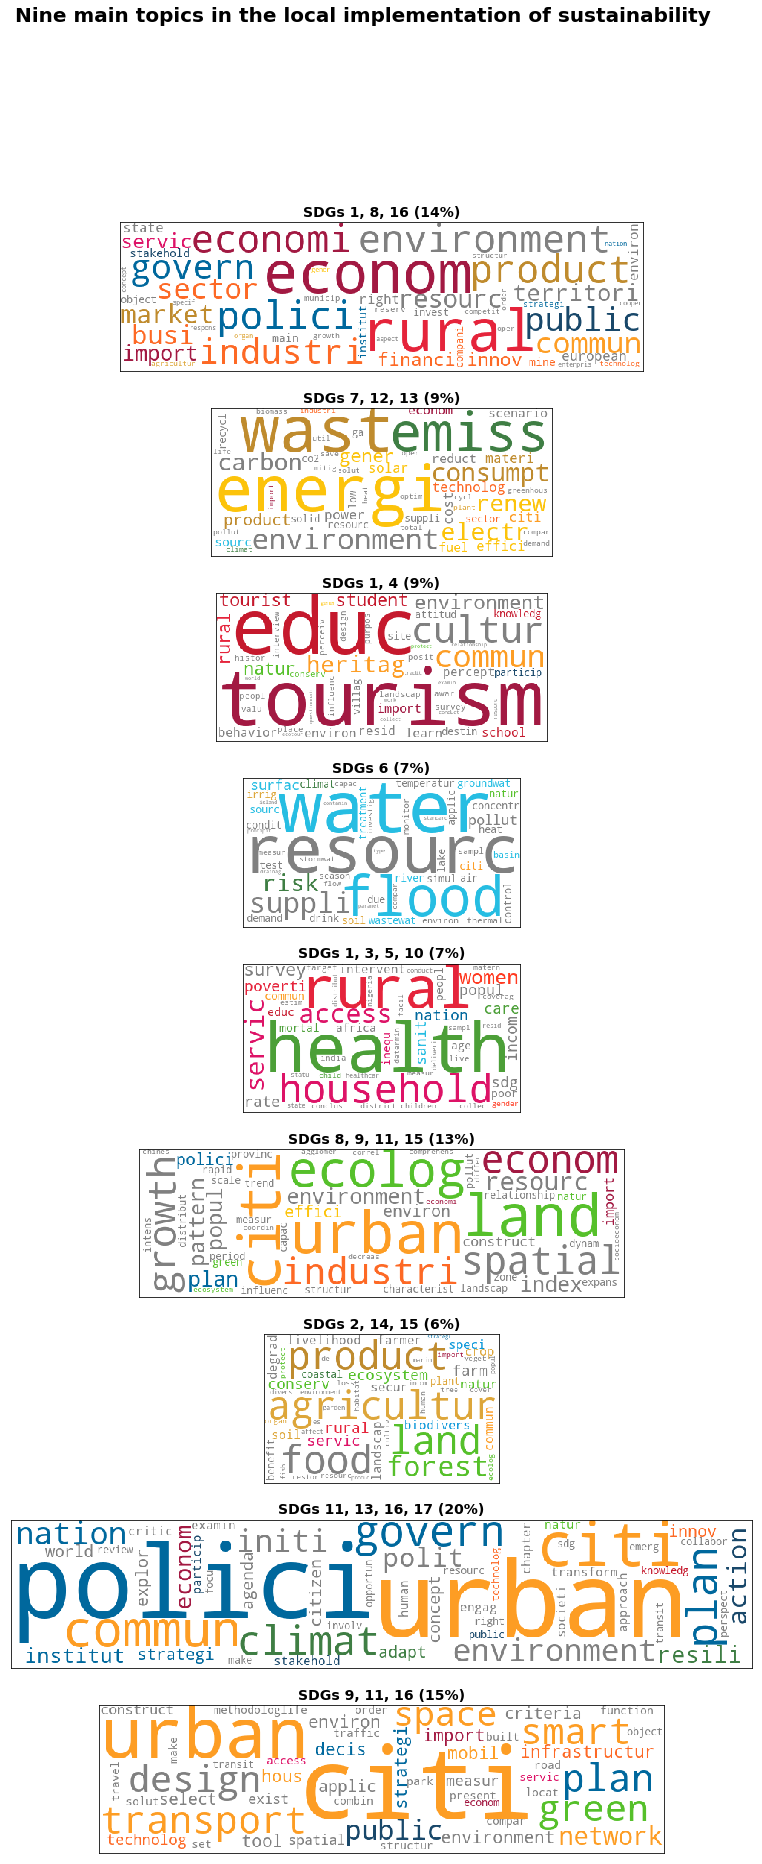

In [36]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import seaborn as sns

grid = gridspec.GridSpec(9, 1) 
grid.update(wspace = 0.1,
            hspace = .25)


figure = plt.figure()
figure.set_figwidth(20)
figure.set_figheight(30)
axes = {}


for i in range(9):
    axes[i] = plt.subplot(grid[i, 0])
    axes[i].grid('off')
    axes[i].set_xticklabels([])
    axes[i].set_yticklabels([])
    axes[i].get_xaxis().set_ticks([])
    axes[i].get_yaxis().set_ticks([])


n_top_words = 50
model_counts = np.array(model7.nzw_).T


ax_i = [3, 8, 0, 6, 7, 5, 2, 1, 4]
for i, topic in enumerate(topic_word):
    topic_words = word_array[np.argsort(topic)][:-n_top_words:-1]
    word_cloud_string =' '.join(topic_words)
    fr = topic_fraction[i]/max(topic_fraction)
    w = int(fr * 1000)
    wordcloudobj = WordCloud(height=200, width=w, background_color='white')
    wordcloud = wordcloudobj.generate(word_cloud_string)
   
    color_to_words = {
        # words below will be colored with a  single color function

        #'SDG1'
        '#e5243b': ['rural', 'poverti'], 
        #'SDG2' 
        '#dda63a': ['soil', 'crop', 'irrig', 'organ', 'yield', 'fertil', 'agricultur', 'plant'],
        #'SDG3'
        '#4c9f38': ['health', 'care', 'mortal', 'child', 'death'],
        #'SDG4' 
        '#c5192d': ['educ', 'knowledg', 'student', 'tourist', 'school'],
        #'SDG5' 
        '#ff3a21': ['women', 'gender'],
        #'SDG6' 
        '#26bde2': ['water', 'groundwat', 'surfac', 'treatment', 'river', 'flood', 'basin', 'sourc', 'wastewat', 'sanit'],
        #'SDG7'
        '#fcc30b': ['energi', 'effici', 'electr', 'gener', 'renew', 'solar', 'fuel'],
        #'SDG8' 
        '#a21942': ['tourism', 'econom', 'import', 'economi'], 
        #'SDG9' 
        '#fd6925': ['industri', 'compani', 'busi', 'sector', 'mine', 'infrastructur', 'technolog', 'financi', 'innov'],    
        #'SDG10' 
        '#dd1367': ['access', 'servic', 'household', 'inequ'],
        #'SDG11' 
        '#fd9d24': ['urban', 'citi', 'commun', 'region', 'transport', 'space', 'heritag', 'smart', 'network', 'hous', 'mobil'],  
        #'SDG12' 
        '#bf8b2e': ['product', 'wast', 'consumpt', 'materi', 'market'],
        #'SDG13' 
        '#3f7e44': ['chang', 'climat', 'risk', 'impact', 'coastal', 'protect', 'emiss', 'resili', 'adapt'], 
        #'SDG14' 
        '#0a97d9': ['speci', 'biodivers'], 
        #'SDG15' 
        '#56c02b': ['land', 'forest', 'ecosystem', 'conserv', 'green','ecolog', 'protect', 'natur'],    
        #'SDG16' 
        '#00689d': ['nation', 'institut', 'plan', 'decis', 'strategi', 'polici', 'govern'],
        #'SDG17' 
        '#19486a': ['public', 'action', 'stakehold', 'particip']

    }

    # Words that are not in any of the color_to_words values
    # will be colored with a grey single color function
    #they represent words which can be multi-purpose and be used in different SDGs, e.g. product, environment, resource, land.
    
    default_color = 'grey'

    # Create a color function with single tone
    grouped_color_func = SimpleGroupedColorFunc(color_to_words, default_color)

    # Create a color function with multiple tones
    #grouped_color_func = GroupedColorFunc(color_to_words, grey_color_func)

    # Apply our color function
    axes[ax_i[i]].imshow(wordcloud.recolor(color_func=grouped_color_func, random_state=0))
    axes[ax_i[i]].set_title(topic_titles[i]+' ({}%)'.format(int(round((100*topic_fraction[i])))), fontsize=14, fontweight='bold')


plt.suptitle("Nine main topics in the local implementation of sustainability", fontsize=20, fontweight='bold')
plt.savefig(directory+'wordcloud_Dataset2_9topics_April20.png', dpi=800)
plt.show()    

    